# Nerual Network for Binary Classification of IPO Underpricing

### References
[PyTorch - Binary Classification](https://towardsdatascience.com/pytorch-tabular-binary-classification-a0368da5bb89)

[PyTorch for deep learning binary classification logistic regression](https://medium.com/analytics-vidhya/pytorch-for-deep-learning-binary-classification-logistic-regression-382abd97fb43)

In [99]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import resample
from sklearn.metrics import accuracy_score

## Load Data

In [100]:
data = pd.read_csv('../data/clean_bloomberg_with_sectors.csv')
ipo_labels = data['Underpriced'].tolist()
ipo_features = data._get_numeric_data().columns.values.tolist()[1:-1]
ipo_features.remove('Offer To 1st Close')
x = data[ipo_features]
y = torch.tensor(data.loc[:, 'Underpriced'])
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=351)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

<AxesSubplot:xlabel='Underpriced', ylabel='count'>

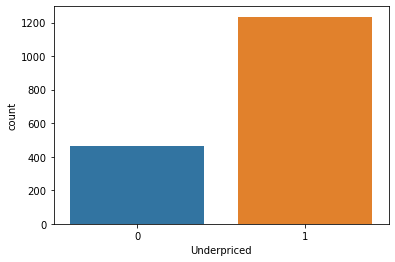

In [101]:
sns.countplot(x = 'Underpriced', data=data)

## Hyperparameters
**Epochs:**        Total number of iterations of the training loop. \
**Batch Size:**    The number of samples that will be propagated through the network. \
**Learning Rate:** Determines the step size at each iteration while moving towards minimum loss.

In [102]:
EPOCHS = 20
BATCH_SIZE = 64
LEARNING_RATE = 0.001

## Train and Test Split

In [103]:
# train data
class TrainData(Dataset):
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

# test data    
class TestData(Dataset):
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)

# Split train and test data
train_data = TrainData(torch.FloatTensor(X_train), y_train)
test_data = TestData(torch.FloatTensor(X_test))

In [104]:
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=1)

## Neural Network Architecture

We create a 2-layer Feed-Forward network with BatchNorm and Dropout.

Our data has 14 features, so our networks input `nn.Linear` layer is length 14.

In [105]:
class BinaryClassification(nn.Module):
    def __init__(self):
        super(BinaryClassification, self).__init__()
        # Number of input features is 14.
        self.layer_1 = nn.Linear(14, 64) 
        self.layer_2 = nn.Linear(64, 64)
        self.layer_out = nn.Linear(64, 1) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(64)
        self.batchnorm2 = nn.BatchNorm1d(64)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.layer_out(x)
        
        return x

In [106]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [107]:
model = BinaryClassification()
model.to(device)
# print(model)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [108]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

## Training Loop
The following chunk runs a training loop on the data to adjust the weights of the neural network using back propogation. We run the loop based on the `EPOCHS` hyperparameter.

It's important not to overtrain the data or the model will become overfit on the training data and usually won't perform well on the test data.

In [109]:
model.train()
losses = []
accur = []
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        
        y_pred = model(X_batch)
        
        loss = criterion(y_pred, y_batch.unsqueeze(1).float())
        acc = binary_acc(y_pred, y_batch.unsqueeze(1).float())
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
        loss =  epoch_loss/len(train_loader)
        acc = epoch_acc/len(train_loader)
                               
    losses.append(loss)
    accur.append(acc)
    print ("epoch: {:<3} | loss: {:<6.5f} | accuracy: {:<10.5f}".format(e, loss, acc))

epoch: 1   | loss: 0.66892 | accuracy: 60.05263  
epoch: 2   | loss: 0.62375 | accuracy: 66.21053  
epoch: 3   | loss: 0.59209 | accuracy: 71.31579  
epoch: 4   | loss: 0.57425 | accuracy: 72.05263  
epoch: 5   | loss: 0.55681 | accuracy: 72.73684  
epoch: 6   | loss: 0.53439 | accuracy: 75.26316  
epoch: 7   | loss: 0.53265 | accuracy: 73.94737  
epoch: 8   | loss: 0.51650 | accuracy: 75.78947  
epoch: 9   | loss: 0.50988 | accuracy: 75.73684  
epoch: 10  | loss: 0.50391 | accuracy: 75.63158  
epoch: 11  | loss: 0.49498 | accuracy: 76.10526  
epoch: 12  | loss: 0.48533 | accuracy: 76.57895  
epoch: 13  | loss: 0.47232 | accuracy: 77.63158  
epoch: 14  | loss: 0.46955 | accuracy: 76.10526  
epoch: 15  | loss: 0.46645 | accuracy: 78.15789  
epoch: 16  | loss: 0.45998 | accuracy: 77.47368  
epoch: 17  | loss: 0.46819 | accuracy: 77.63158  
epoch: 18  | loss: 0.45534 | accuracy: 77.94737  
epoch: 19  | loss: 0.45459 | accuracy: 78.31579  
epoch: 20  | loss: 0.43967 | accuracy: 80.42105  


## Test Model
Now we use our model to predict the labels of the test data.

In [110]:
y_pred_list = []
model.eval()
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

## Accuracy
To compute the model's accurary we just count the number of correctly labeled data and divide that by the number of data in the test set.

In [111]:
correct = 0
len(y_pred_list)
for i in range(510):
    if y_test.tolist()[i] == y_pred_list[i]:
        correct += 1
print("Accurary: ", correct / 510)
print(classification_report(y_test, y_pred_list))

Accurary:  0.703921568627451
              precision    recall  f1-score   support

           0       0.43      0.07      0.12       148
           1       0.72      0.96      0.82       362

    accuracy                           0.70       510
   macro avg       0.58      0.52      0.47       510
weighted avg       0.63      0.70      0.62       510



## Graphs

### Loss vs Epochs
The following graph shows the decrease in loss over the number of iterations of the training loop.

Text(0, 0.5, 'loss')

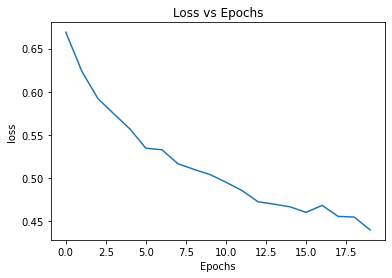

In [112]:
#plotting the loss
plt.plot(losses)
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('loss')

### Accuracy vs Epochs
The following graph shows the increase in the model accurary on the training data over the number of epochs of the training loop.

Text(0, 0.5, 'Accuracy')

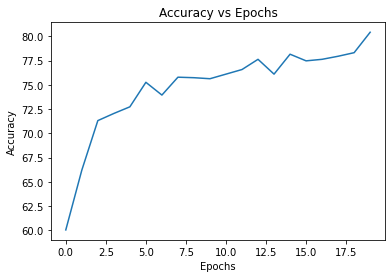

In [113]:
#printing the accuracy
plt.plot(accur)
plt.title('Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

In [114]:
# save the model
torch.save(model.state_dict(), 'saved_models/binary_classification.pt')